SVC, Decision Tree, Random Forest on features. Feature selection

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
from tqdm.auto import tqdm
import pandas as pd

# Features

In [2]:
train_data = {}
for lang in ['RU', 'EN']:
    train_data[lang] = {}
    for part in ['word', 'bigram', 'trigram']:
        data = []
        for text_type in ['lit', 'gpt2', 'balaboba']:
            a = pd.read_csv(f"features/Train_{lang}_{text_type}_{part}_features.csv")
            a['text_type'] = text_type
            data.append(a)
        train_data[lang][part] = pd.concat(data, ignore_index=True)

In [3]:
test_data = {}
for lang in ['RU', 'EN']:
    test_data[lang] = {}
    for part in ['word', 'bigram', 'trigram']:
        data = []
        for text_type in ['lit', 'mGPT', 'lstm']:
            a = pd.read_csv(f"features/Test_{lang}_{text_type}_{part}_features.csv")
            a['text_type'] = text_type
            data.append(a)
        test_data[lang][part] = pd.concat(data, ignore_index=True)

In [7]:
for lang in ['EN', 'RU']:
    for part in ['word', 'bigram', 'trigram']:
        df = train_data[lang][part]
        df[df.columns[-3]] = df[df.columns[-3]].fillna(-1).astype(int)
        df = test_data[lang][part]
        df[df.columns[-3]] = df[df.columns[-3]].fillna(-1).astype(int)

In [8]:
for lang in ['EN', 'RU']:
    for part in ['word', 'bigram', 'trigram']:
        print(sorted(train_data[lang][part].iloc[:,-3].unique()), sorted(test_data[lang][part].iloc[:,-3].unique()))

[0, 1, 2, 3] [0, 1, 2, 3]
[0, 1, 2, 3, 4, 5, 6] [0, 1, 2, 4, 5, 6]
[0, 1, 2, 3, 4] [0, 1, 2, 3, 4]
[0, 1, 2, 5, 6] [0, 1, 2, 3, 5]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11] [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


# Classification functions

In [9]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, average_precision_score

def svc_classifier(X_train, y_train, X_test, y_test):
    svc = LinearSVC(dual=False)
    reg_Cs = np.logspace(-5, 1, 20)
    linear_svc = GridSearchCV(svc, {"C": reg_Cs}, cv=10)    # chooses best by score estimate
    model = linear_svc.fit(X_train, y_train)

    best_model_svc = linear_svc.best_estimator_
    train_score = best_model_svc.score(X_train, y_train)
    test_score = best_model_svc.score(X_test, y_test)
    
    b_pred_svc = best_model_svc.decision_function(X_test)
    auc_roc_svc_ = roc_auc_score(y_test, b_pred_svc)
    auc_pr_svc_ = average_precision_score(y_test, b_pred_svc)
    
    return best_model_svc, {
        'train_acc': train_score, 'test_acc': test_score, 
        'auc_roc_test': auc_roc_svc_, 'auc_pr_test': auc_pr_svc_
    }

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from itertools import product


def decision_tree_classifier(
    X_train, y_train, X_test, y_test, 
    depth_grid=range(3, 16), samples_leaf_grid=range(1, 5), random_forest=False
):
    models = {}
    accuracy = {part: np.zeros((len(depth_grid), len(samples_leaf_grid))) for part in ['train', 'test']}

    for i, depth in tqdm(enumerate(depth_grid), total=len(depth_grid), leave=False):
        for j, samples_leaf in enumerate(samples_leaf_grid):
            if random_forest:
                model = RandomForestClassifier(
                    max_depth = depth, 
                    min_samples_leaf = samples_leaf
                ).fit(X_train, y_train)
            else:
                model = DecisionTreeClassifier(
                    max_depth = depth, 
                    min_samples_leaf = samples_leaf
                ).fit(X_train, y_train)
            pred_train = model.predict(X_train)
            pred = model.predict(X_test)
            accuracy['train'][i, j] = accuracy_score(y_train, pred_train) 
            accuracy['test'][i, j] = accuracy_score(y_test, pred)
            models[(depth, samples_leaf)] = model
    for part in accuracy:
        accuracy[part] = pd.DataFrame(accuracy[part])
        accuracy[part].columns = samples_leaf_grid
        accuracy[part].index = depth_grid
    return models, accuracy

# Dataset

In [10]:
svc_res = {'EN': {}, 'RU': {}}
for lang in ['EN', 'RU']:
    for part in ['word', 'bigram', 'trigram']:
        try:
            train_df = train_data[lang][part]
            test_df = test_data[lang][part]
            res = svc_classifier(
                train_df[train_df.columns[:-2]], train_df[train_df.columns[-1]] == 'lit', 
                test_df[test_df.columns[:-2]], test_df[test_df.columns[-1]] == 'lit'
            )
            svc_res[lang][part] = res
            print(lang, part)
            print(res[1])
            print('*' * 10)
        except:
            continue

EN word
{'train_acc': 0.95975, 'test_acc': 0.8441666666666666, 'auc_roc_test': 0.94275, 'auc_pr_test': 0.9485360605455366}
**********
EN bigram
{'train_acc': 0.96275, 'test_acc': 0.9408333333333333, 'auc_roc_test': 0.9771111111111112, 'auc_pr_test': 0.9782454728238364}
**********
EN trigram
{'train_acc': 0.906, 'test_acc': 0.755, 'auc_roc_test': 0.9047916666666667, 'auc_pr_test': 0.9196315733514229}
**********
RU word
{'train_acc': 0.9826720241084882, 'test_acc': 0.7433110367892977, 'auc_roc_test': 0.9415911633109622, 'auc_pr_test': 0.9487380126320418}
**********
RU bigram
{'train_acc': 0.9721245605223505, 'test_acc': 0.7138075313807531, 'auc_roc_test': 0.6327268041814658, 'auc_pr_test': 0.5917046364731295}
**********
RU trigram
{'train_acc': 0.9611895161290323, 'test_acc': 0.7181434599156118, 'auc_roc_test': 0.6788206808146988, 'auc_pr_test': 0.6143500261774026}
**********


In [11]:
np.save("classification/svc_gpt2_balaboba.npy", svc_res)

In [14]:
dt_res = {'EN': {}, 'RU': {}}
for lang in ['EN', 'RU']:
    for part in ['word', 'bigram', 'trigram']:
        try:
            train_df = train_data[lang][part]
            test_df = test_data[lang][part]
            res = decision_tree_classifier(
                train_df[train_df.columns[:-2]], train_df[train_df.columns[-1]] == 'lit', 
                test_df[test_df.columns[:-2]], test_df[test_df.columns[-1]] == 'lit'
            )
            dt_res[lang][part] = res
            print(lang, part)
            print(res[1])
            print('*' * 10)
        except:
            continue

  0%|          | 0/13 [00:00<?, ?it/s]

EN word
{'train':           1        2        3        4
3   0.95575  0.95575  0.95575  0.95575
4   0.96350  0.96325  0.96300  0.96275
5   0.97025  0.96975  0.96925  0.96850
6   0.97925  0.97875  0.97775  0.97650
7   0.98550  0.98325  0.98100  0.97925
8   0.99175  0.98775  0.98525  0.98325
9   0.99550  0.99025  0.98650  0.98450
10  0.99675  0.99125  0.98800  0.98450
11  0.99775  0.99150  0.98800  0.98525
12  0.99950  0.99200  0.98775  0.98500
13  0.99975  0.99225  0.98750  0.98500
14  1.00000  0.99225  0.98775  0.98500
15  1.00000  0.99225  0.98775  0.98500, 'test':            1         2         3         4
3   0.831667  0.831667  0.831667  0.831667
4   0.843333  0.843333  0.843333  0.843333
5   0.847500  0.845833  0.847500  0.845833
6   0.849167  0.848333  0.845833  0.846667
7   0.847500  0.850000  0.840833  0.845833
8   0.845833  0.845000  0.837500  0.833333
9   0.844167  0.840000  0.839167  0.832500
10  0.845833  0.840000  0.836667  0.826667
11  0.840000  0.840000  0.830833  0.8300

  0%|          | 0/13 [00:00<?, ?it/s]

EN bigram
{'train':           1        2        3        4
3   0.94450  0.94450  0.94450  0.94450
4   0.95350  0.95325  0.95300  0.95300
5   0.96550  0.96525  0.96425  0.96375
6   0.97650  0.97550  0.97375  0.97200
7   0.98600  0.98325  0.98025  0.97725
8   0.98800  0.98475  0.98125  0.97875
9   0.99175  0.98825  0.98450  0.98125
10  0.99400  0.99050  0.98600  0.98125
11  0.99475  0.99075  0.98700  0.98125
12  0.99675  0.99075  0.98700  0.98125
13  0.99800  0.99125  0.98700  0.98125
14  0.99950  0.99125  0.98650  0.98125
15  0.99975  0.99125  0.98675  0.98125, 'test':            1         2         3         4
3   0.855833  0.855833  0.855833  0.855833
4   0.850833  0.853333  0.852500  0.852500
5   0.856667  0.859167  0.857500  0.860000
6   0.879167  0.869167  0.872500  0.872500
7   0.868333  0.869167  0.860833  0.867500
8   0.850833  0.861667  0.855833  0.860000
9   0.830000  0.860000  0.863333  0.864167
10  0.837500  0.860000  0.860833  0.873333
11  0.804167  0.848333  0.853333  0.87

  0%|          | 0/13 [00:00<?, ?it/s]

EN trigram
{'train':           1        2        3        4
3   0.89425  0.89425  0.89425  0.89425
4   0.90975  0.90975  0.90975  0.90975
5   0.92600  0.92575  0.92575  0.92550
6   0.94125  0.93975  0.93850  0.93750
7   0.95400  0.95125  0.95050  0.94750
8   0.96800  0.96350  0.96125  0.95675
9   0.97800  0.97075  0.96650  0.96125
10  0.98350  0.97425  0.97125  0.96250
11  0.98800  0.97725  0.97350  0.96475
12  0.99075  0.97850  0.97475  0.96600
13  0.99300  0.97975  0.97575  0.96700
14  0.99400  0.98100  0.97625  0.96725
15  0.99575  0.98275  0.97600  0.96700, 'test':            1         2         3         4
3   0.780000  0.780000  0.780000  0.780000
4   0.804167  0.804167  0.804167  0.804167
5   0.807500  0.807500  0.807500  0.811667
6   0.786667  0.794167  0.808333  0.811667
7   0.775833  0.783333  0.800833  0.809167
8   0.789167  0.795833  0.795833  0.819167
9   0.779167  0.790000  0.803333  0.811667
10  0.793333  0.785833  0.793333  0.800833
11  0.785833  0.783333  0.796667  0.8

  0%|          | 0/13 [00:00<?, ?it/s]

RU word
{'train':            1         2         3         4
3   0.971120  0.971120  0.971120  0.971120
4   0.980161  0.979910  0.979407  0.979156
5   0.986941  0.985686  0.984932  0.983928
6   0.991462  0.990457  0.989453  0.988197
7   0.994977  0.993471  0.992215  0.990457
8   0.997489  0.994977  0.993973  0.991462
9   0.998493  0.996986  0.994475  0.991713
10  0.999749  0.996735  0.994726  0.992215
11  1.000000  0.996484  0.994726  0.991713
12  1.000000  0.996484  0.994475  0.991964
13  1.000000  0.996484  0.994475  0.992466
14  1.000000  0.996233  0.994977  0.992215
15  1.000000  0.996986  0.994475  0.992466, 'test':            1         2         3         4
3   0.724080  0.724080  0.724080  0.724080
4   0.721572  0.721572  0.698997  0.721572
5   0.729933  0.759197  0.734950  0.757525
6   0.737458  0.757525  0.760033  0.757525
7   0.740803  0.760870  0.729933  0.729933
8   0.745819  0.750836  0.774247  0.748328
9   0.750836  0.727425  0.729097  0.730769
10  0.747492  0.725753  0.7

  0%|          | 0/13 [00:00<?, ?it/s]

RU bigram
{'train':            1         2         3         4
3   0.940231  0.940231  0.940231  0.940231
4   0.958061  0.958061  0.958061  0.958061
5   0.971622  0.971120  0.971120  0.970618
6   0.978905  0.976394  0.975640  0.974134
7   0.986690  0.983174  0.982923  0.982923
8   0.991964  0.987946  0.988448  0.986690
9   0.994977  0.989453  0.990206  0.987946
10  0.996233  0.989704  0.990206  0.987695
11  0.998242  0.990708  0.990206  0.987695
12  0.998242  0.991210  0.990206  0.987695
13  0.998744  0.991964  0.990457  0.987695
14  0.999247  0.992215  0.990457  0.987443
15  0.999749  0.992466  0.990708  0.987695, 'test':            1         2         3         4
3   0.701255  0.701255  0.701255  0.701255
4   0.698745  0.698745  0.698745  0.698745
5   0.702929  0.701255  0.701255  0.701255
6   0.701255  0.703766  0.703766  0.702929
7   0.693724  0.697071  0.697071  0.702092
8   0.688703  0.700418  0.698745  0.697908
9   0.692050  0.702929  0.698745  0.700418
10  0.687029  0.704603  0

  0%|          | 0/13 [00:00<?, ?it/s]

RU trigram
{'train':            1         2         3         4
3   0.934224  0.934224  0.934224  0.934224
4   0.947581  0.947329  0.947329  0.947329
5   0.957661  0.957157  0.956401  0.955645
6   0.972782  0.971270  0.970514  0.967994
7   0.981099  0.978579  0.977319  0.975554
8   0.987147  0.983871  0.981099  0.978327
9   0.991431  0.986139  0.983367  0.980595
10  0.993952  0.988155  0.984123  0.980847
11  0.994456  0.989163  0.984879  0.980847
12  0.995716  0.989163  0.985635  0.980847
13  0.996724  0.990171  0.986391  0.980847
14  0.997480  0.991431  0.986391  0.980847
15  0.998740  0.991431  0.986895  0.982611, 'test':            1         2         3         4
3   0.746835  0.746835  0.746835  0.746835
4   0.730802  0.730802  0.730802  0.730802
5   0.707173  0.708861  0.705485  0.708017
6   0.720675  0.720675  0.721519  0.719831
7   0.728270  0.728270  0.726582  0.735021
8   0.728270  0.729958  0.724895  0.731646
9   0.737553  0.734177  0.738397  0.724895
10  0.737553  0.751899  

In [90]:
np.save('classification/dt_gpt2_balaboba.npy', dt_res)

In [15]:
rf_res = {'EN': {}, 'RU': {}}
for lang in ['EN', 'RU']:
    for part in ['word', 'bigram', 'trigram']:
        try:
            train_df = train_data[lang][part]
            test_df = test_data[lang][part]
            res = decision_tree_classifier(
                train_df[train_df.columns[:-2]], train_df[train_df.columns[-1]] == 'lit', 
                test_df[test_df.columns[:-2]], test_df[test_df.columns[-1]] == 'lit', random_forest=True
            )
            rf_res[lang][part] = res
            print(lang, part)
            print(res[1]['train'].max(), res[1]['test'].max())
            print('*' * 10)
        except:
            continue

  0%|          | 0/13 [00:00<?, ?it/s]

EN word
1    1.00000
2    0.99450
3    0.99075
4    0.98750
dtype: float64 1    0.856667
2    0.855000
3    0.855000
4    0.855000
dtype: float64
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN bigram
1    1.0000
2    0.9970
3    0.9915
4    0.9870
dtype: float64 1    0.926667
2    0.925000
3    0.930000
4    0.923333
dtype: float64
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN trigram
1    0.99925
2    0.99250
3    0.98050
4    0.97475
dtype: float64 1    0.923333
2    0.927500
3    0.924167
4    0.924167
dtype: float64
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU word
1    1.000000
2    0.999498
3    0.996986
4    0.996233
dtype: float64 1    0.749164
2    0.755853
3    0.744983
4    0.745819
dtype: float64
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU bigram
1    1.000000
2    0.999498
3    0.997238
4    0.992968
dtype: float64 1    0.725523
2    0.720502
3    0.719665
4    0.721339
dtype: float64
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU trigram
1    0.999748
2    0.997228
3    0.995212
4    0.991431
dtype: float64 1    0.755274
2    0.748523
3    0.748523
4    0.745992
dtype: float64
**********


In [96]:
np.save('classification/rf_gpt2_balaboba.npy', rf_res)

# Cross

In [65]:
import glob
np.random.seed(2024)
bot_names = ['lstm', 'balaboba', 'gpt2', 'mGPT']
def get_train_test_datasets(lang="RU", part="word", bot_subset=("gpt2", "balaboba")):
    def read_subdf(filename, text_type):
        a = pd.read_csv(filename)
        a[a.columns[-2]] = a[a.columns[-2]].astype(int)
        a['text_type'] = text_type
        return a
    
    lit_train = read_subdf(f"features/Train_{lang}_lit_{part}_features.csv", "lit")
    
    ## Crop for all cases except for dataset
    lit_train_idx = np.random.choice(len(lit_train), 600)
    lit_train = lit_train.iloc[lit_train_idx].reset_index(drop=True)    
    
    lit_test = read_subdf(f"features/Test_{lang}_lit_{part}_features.csv", "lit")
    
    bot_train = []
    bot_test = []
    for text_type in bot_names:
        fn = glob.glob(f"features/*_{lang}_{text_type}_{part}_features.csv")[0]
        bot_df = read_subdf(fn, text_type)
        if len(bot_df) > 300:
            idx = np.random.choice(len(bot_df), 300)
            bot_df = bot_df.iloc[idx].reset_index(drop=True)    
        if text_type in bot_subset:
            bot_train.append(bot_df)
        else:
            bot_test.append(bot_df)
    return (
        pd.concat([lit_train] + bot_train).reset_index(drop=True),
        pd.concat([lit_test] + bot_test).reset_index(drop=True)
    )

In [106]:
def pipeline_clf(bot_subset, method='svc'):
    results = {'EN': {}, 'RU': {}}
    for lang in ['EN', 'RU']:
        for part in ['word', 'bigram', 'trigram']:
            try:
                train_df, test_df = get_train_test_datasets(lang, part, bot_subset)
                # print("\tTrain text types:", train_df.text_type.unique())
                # print("\tTest text types:", test_df.text_type.unique())
                # print("\n")
                if method == 'svc':
                    res = svc_classifier(
                        train_df[train_df.columns[:-2]], train_df[train_df.columns[-1]] == 'lit', 
                        test_df[test_df.columns[:-2]], test_df[test_df.columns[-1]] == 'lit'
                    )
                elif method == 'dt':
                    res = decision_tree_classifier(
                        train_df[train_df.columns[:-2]], train_df[train_df.columns[-1]] == 'lit', 
                        test_df[test_df.columns[:-2]], test_df[test_df.columns[-1]] == 'lit'
                    )
                elif method == 'rf':
                    res = decision_tree_classifier(
                        train_df[train_df.columns[:-2]], train_df[train_df.columns[-1]] == 'lit', 
                        test_df[test_df.columns[:-2]], test_df[test_df.columns[-1]] == 'lit',
                        random_forest=True
                    )
                results[lang][part] = res
                print(lang, part)
                if method == 'svc':
                    print(res[1])
                else:
                    print(res[1]['train'].values.max(), res[1]['test'].values.max())
                print('*' * 10)
            except:
                continue
    return results

In [66]:
train_data, test_data = get_train_test_datasets("RU", "word", ('lstm', 'balaboba'))

In [18]:
bot_names = ['lstm', 'balaboba', 'gpt2', 'mGPT']

In [109]:
list(combinations(bot_names, r=2))

[('lstm', 'balaboba'),
 ('lstm', 'gpt2'),
 ('lstm', 'mGPT'),
 ('balaboba', 'gpt2'),
 ('balaboba', 'mGPT'),
 ('gpt2', 'mGPT')]

In [107]:
from itertools import combinations
method = "svc"
for bot_subset in tqdm(combinations(bot_names, r=2), total=6):
    if sorted(bot_subset) == ['balaboba', 'gpt2']: continue
    print(bot_subset)
    res = pipeline_clf(bot_subset, method)
    save_file = f"classification/{method}_{bot_subset[0]}_{bot_subset[1]}.npy"
    np.save(save_file, res)
    print("*" * 50)
    print("\n\n")

  0%|          | 0/5 [00:00<?, ?it/s]

('lstm', 'balaboba')
EN word
{'train_acc': 0.8791666666666667, 'test_acc': 0.9216666666666666, 'auc_roc_test': 0.9635499999999999, 'auc_pr_test': 0.9617800567270754}
**********
EN bigram
{'train_acc': 0.9466666666666667, 'test_acc': 0.94, 'auc_roc_test': 0.9810583333333334, 'auc_pr_test': 0.9808498271782691}
**********
EN trigram
{'train_acc': 0.9216666666666666, 'test_acc': 0.8858333333333334, 'auc_roc_test': 0.9443999999999999, 'auc_pr_test': 0.9269972915923191}
**********
RU word
{'train_acc': 0.93, 'test_acc': 0.9163879598662207, 'auc_roc_test': 0.9710262863534675, 'auc_pr_test': 0.9695137384962567}
**********
RU bigram
{'train_acc': 0.9616666666666667, 'test_acc': 0.9372384937238494, 'auc_roc_test': 0.9744456644743477, 'auc_pr_test': 0.9527721519961833}
**********
RU trigram
{'train_acc': 0.9633333333333334, 'test_acc': 0.9341772151898734, 'auc_roc_test': 0.9688990172340123, 'auc_pr_test': 0.9337620239434523}
**********
**************************************************



('lstm'

In [110]:
from itertools import combinations
method = "dt"
for bot_subset in tqdm(combinations(bot_names, r=2), total=6):
    if sorted(bot_subset) == ['balaboba', 'gpt2']: continue
    print(bot_subset)
    res = pipeline_clf(bot_subset, method)
    save_file = f"classification/{method}_{bot_subset[0]}_{bot_subset[1]}.npy"
    np.save(save_file, res)
    print("*" * 50)
    print("\n\n")

  0%|          | 0/6 [00:00<?, ?it/s]

('lstm', 'balaboba')


  0%|          | 0/13 [00:00<?, ?it/s]

EN word
1.0 0.9316666666666666
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN bigram
1.0 0.935
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN trigram
1.0 0.8783333333333333
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU word
1.0 0.9080267558528428
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU bigram
1.0 0.8861924686192468
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU trigram
1.0 0.8860759493670886
**********
**************************************************



('lstm', 'gpt2')


  0%|          | 0/13 [00:00<?, ?it/s]

EN word
1.0 0.8891666666666667
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN bigram
1.0 0.9141666666666667
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN trigram
1.0 0.8125
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU word
1.0 0.9255852842809364
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU bigram
1.0 0.8761506276150628
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU trigram
1.0 0.8827004219409282
**********
**************************************************



('lstm', 'mGPT')


  0%|          | 0/13 [00:00<?, ?it/s]

EN word
1.0 0.7675
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN bigram
1.0 0.8658333333333333
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN trigram
1.0 0.7933333333333333
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU word
1.0 0.9280936454849499
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU bigram
1.0 0.8277591973244147
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU trigram
1.0 0.8594142259414226
**********
**************************************************



('balaboba', 'mGPT')


  0%|          | 0/13 [00:00<?, ?it/s]

EN word
1.0 0.8283333333333334
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN bigram
1.0 0.9175
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN trigram
1.0 0.9016666666666666
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU word
1.0 0.8678929765886287
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU bigram
1.0 0.7123745819397993
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU trigram
1.0 0.9271966527196652
**********
**************************************************



('gpt2', 'mGPT')


  0%|          | 0/13 [00:00<?, ?it/s]

EN word
1.0 0.84
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN bigram
1.0 0.8658333333333333
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN trigram
1.0 0.8841666666666667
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU word
1.0 0.7792642140468228
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU bigram
1.0 0.7081939799331104
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU trigram
1.0 0.7372384937238494
**********
**************************************************





In [111]:
from itertools import combinations
method = "rf"
for bot_subset in tqdm(combinations(bot_names, r=2), total=6):
    if sorted(bot_subset) == ['balaboba', 'gpt2']: continue
    print(bot_subset)
    res = pipeline_clf(bot_subset, method)
    save_file = f"classification/{method}_{bot_subset[0]}_{bot_subset[1]}.npy"
    np.save(save_file, res)
    print("*" * 50)
    print("\n\n")

  0%|          | 0/6 [00:00<?, ?it/s]

('lstm', 'balaboba')


  0%|          | 0/13 [00:00<?, ?it/s]

EN word
1.0 0.935
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN bigram
1.0 0.9641666666666666
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN trigram
1.0 0.9141666666666667
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU word
1.0 0.8954849498327759
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU bigram
1.0 0.9288702928870293
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU trigram
1.0 0.9426160337552743
**********
**************************************************



('lstm', 'gpt2')


  0%|          | 0/13 [00:00<?, ?it/s]

EN word
1.0 0.92
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN bigram
1.0 0.9291666666666667
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN trigram
1.0 0.8825
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU word
1.0 0.9214046822742475
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU bigram
1.0 0.9171548117154812
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU trigram
1.0 0.9468354430379747
**********
**************************************************



('lstm', 'mGPT')


  0%|          | 0/13 [00:00<?, ?it/s]

EN word
1.0 0.7733333333333333
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN bigram
1.0 0.8558333333333333
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN trigram
1.0 0.7466666666666667
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU word
1.0 0.9448160535117057
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU bigram
1.0 0.9113712374581939
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU trigram
1.0 0.8794979079497908
**********
**************************************************



('balaboba', 'mGPT')


  0%|          | 0/13 [00:00<?, ?it/s]

EN word
1.0 0.8608333333333333
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN bigram
1.0 0.9633333333333334
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN trigram
1.0 0.9091666666666667
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU word
1.0 0.7951505016722408
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU bigram
1.0 0.7366220735785953
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU trigram
1.0 0.7372384937238494
**********
**************************************************



('gpt2', 'mGPT')


  0%|          | 0/13 [00:00<?, ?it/s]

EN word
1.0 0.8516666666666667
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN bigram
1.0 0.8958333333333334
**********


  0%|          | 0/13 [00:00<?, ?it/s]

EN trigram
1.0 0.87
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU word
1.0 0.774247491638796
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU bigram
1.0 0.7115384615384616
**********


  0%|          | 0/13 [00:00<?, ?it/s]

RU trigram
1.0 0.7347280334728034
**********
**************************************************





# Result tables

In [6]:
from itertools import combinations
bot_names = ['lstm', 'balaboba', 'gpt2', 'mGPT']
results = {method: {} for method in ['svc', 'dt', 'rf']}
for method in results:
    for bot_subset in list(combinations(bot_names, r=2)):
        results[method][bot_subset] = np.load(f"classification/{method}_{bot_subset[0]}_{bot_subset[1]}.npy", allow_pickle=True).item()

In [43]:
bot_subsets = list(combinations(bot_names, r=2))
def get_acc_values(results, method = 'svc', lang='RU', part='word'):
    clf_res = []
    for bot_subset in bot_subsets:
        r = results[method][bot_subset][lang][part][1]
        if method == 'svc':
            clf_res.extend([r['train_acc'], r['test_acc']])
        else:
            idx_max = np.unravel_index(np.argmax(r['test'].to_numpy(), axis=None), r['test'].shape)
            clf_res.extend([r['train'].iloc[idx_max], r['test'].iloc[idx_max]])
    return clf_res

In [74]:
columns = np.array([("Train: "+"+".join(bot_subset), "Test: "+"+".join(list(set(bot_names) - set(bot_subset)))) for bot_subset in bot_subsets]).flatten()
columns

array(['Train: lstm+balaboba', 'Test: gpt2+mGPT', 'Train: lstm+gpt2',
       'Test: mGPT+balaboba', 'Train: lstm+mGPT', 'Test: gpt2+balaboba',
       'Train: balaboba+gpt2', 'Test: mGPT+lstm', 'Train: balaboba+mGPT',
       'Test: gpt2+lstm', 'Train: gpt2+mGPT', 'Test: balaboba+lstm'],
      dtype='<U20')

In [76]:
lang = 'RU'
part = 'word'

clf_tables = {'RU': {}, 'EN': {}}

for lang in ['RU', 'EN']:
    for part in ['word', 'bigram', 'trigram']:
        svc_results = get_acc_values(results, 'svc', lang, part)
        dt_results = get_acc_values(results, 'dt', lang, part)
        rf_results = get_acc_values(results, 'rf', lang, part)
        
        clf_tables[lang][part] = pd.DataFrame(
            np.vstack([svc_results, dt_results, rf_results]), 
            index=['SVC', 'DT', 'RF'], 
            columns=columns
        )

In [77]:
for lang in ['RU', 'EN']:
    for part in ['word', 'bigram', 'trigram']:
        print(lang, part)
        display(clf_tables[lang][part])

RU word


,Train: lstm+balaboba,Test: gpt2+mGPT,Train: lstm+gpt2,Test: mGPT+balaboba,Train: lstm+mGPT,Test: gpt2+balaboba,Train: balaboba+gpt2,Test: mGPT+lstm,Train: balaboba+mGPT,Test: gpt2+lstm,Train: gpt2+mGPT,Test: balaboba+lstm
SVC,0.930000,0.916388,0.946667,0.895485,0.939167,0.952341,0.982672,0.743311,0.963333,0.779264,0.970833,0.729097
DT,0.979167,0.908027,0.932500,0.925585,0.980000,0.928094,0.993973,0.774247,0.981667,0.867893,0.964167,0.779264
RF,0.997500,0.895485,1.000000,0.921405,0.974167,0.944816,0.997991,0.755853,1.000000,0.795151,0.991667,0.774247


RU bigram


,Train: lstm+balaboba,Test: gpt2+mGPT,Train: lstm+gpt2,Test: mGPT+balaboba,Train: lstm+mGPT,Test: gpt2+balaboba,Train: balaboba+gpt2,Test: mGPT+lstm,Train: balaboba+mGPT,Test: gpt2+lstm,Train: gpt2+mGPT,Test: balaboba+lstm
SVC,0.961667,0.937238,0.975000,0.851883,0.985822,0.790134,0.972125,0.713808,0.974145,0.727425,0.988324,0.703177
DT,0.995000,0.886192,0.921667,0.876151,0.980817,0.827759,0.989704,0.704603,1.000000,0.712375,1.000000,0.708194
RF,1.000000,0.928870,1.000000,0.917155,0.994996,0.911371,1.000000,0.725523,1.000000,0.736622,0.999166,0.711538


RU trigram


,Train: lstm+balaboba,Test: gpt2+mGPT,Train: lstm+gpt2,Test: mGPT+balaboba,Train: lstm+mGPT,Test: gpt2+balaboba,Train: balaboba+gpt2,Test: mGPT+lstm,Train: balaboba+mGPT,Test: gpt2+lstm,Train: gpt2+mGPT,Test: balaboba+lstm
SVC,0.963333,0.934177,0.970833,0.924051,0.963866,0.884519,0.961190,0.718143,0.964706,0.720502,0.961345,0.704603
DT,0.986667,0.886076,0.980000,0.882700,0.987395,0.859414,0.989163,0.821941,0.992437,0.927197,0.991597,0.737238
RF,0.992500,0.942616,1.000000,0.946835,0.996639,0.879498,0.999748,0.755274,1.000000,0.737238,1.000000,0.734728


EN word


,Train: lstm+balaboba,Test: gpt2+mGPT,Train: lstm+gpt2,Test: mGPT+balaboba,Train: lstm+mGPT,Test: gpt2+balaboba,Train: balaboba+gpt2,Test: mGPT+lstm,Train: balaboba+mGPT,Test: gpt2+lstm,Train: gpt2+mGPT,Test: balaboba+lstm
SVC,0.879167,0.921667,0.919167,0.902500,0.8775,0.770833,0.95975,0.844167,0.958333,0.840000,0.971667,0.802500
DT,0.990000,0.931667,0.983333,0.889167,0.9725,0.767500,0.98325,0.850000,0.949167,0.828333,0.985833,0.840000
RF,0.997500,0.935000,0.983333,0.920000,0.9800,0.773333,0.99750,0.856667,0.989167,0.860833,0.996667,0.851667


EN bigram


,Train: lstm+balaboba,Test: gpt2+mGPT,Train: lstm+gpt2,Test: mGPT+balaboba,Train: lstm+mGPT,Test: gpt2+balaboba,Train: balaboba+gpt2,Test: mGPT+lstm,Train: balaboba+mGPT,Test: gpt2+lstm,Train: gpt2+mGPT,Test: balaboba+lstm
SVC,0.946667,0.940000,0.971667,0.925000,0.964167,0.868333,0.96275,0.940833,0.959167,0.940000,0.968333,0.878333
DT,0.975000,0.935000,1.000000,0.914167,0.989167,0.865833,0.97650,0.879167,1.000000,0.917500,0.992500,0.865833
RF,0.990000,0.964167,0.999167,0.929167,0.996667,0.855833,0.99000,0.930000,1.000000,0.963333,0.995833,0.895833


EN trigram


,Train: lstm+balaboba,Test: gpt2+mGPT,Train: lstm+gpt2,Test: mGPT+balaboba,Train: lstm+mGPT,Test: gpt2+balaboba,Train: balaboba+gpt2,Test: mGPT+lstm,Train: balaboba+mGPT,Test: gpt2+lstm,Train: gpt2+mGPT,Test: balaboba+lstm
SVC,0.921667,0.885833,0.951667,0.8300,0.967500,0.840833,0.90600,0.755000,0.892500,0.764167,0.935000,0.721667
DT,0.969167,0.878333,1.000000,0.8125,0.940833,0.793333,0.95675,0.819167,0.975833,0.901667,0.981667,0.884167
RF,0.975833,0.914167,1.000000,0.8825,0.994167,0.746667,0.99250,0.927500,1.000000,0.909167,0.992500,0.870000


In [82]:
for lang in ['RU', 'EN']:
    for part in ['word', 'bigram', 'trigram']:
        clf_tables[lang][part].to_excel(f"classification/excel_tables/{lang}{part}.xlsx", float_format="%.3f")

# Feature importance

In [85]:
bot_subsets

[('lstm', 'balaboba'),
 ('lstm', 'gpt2'),
 ('lstm', 'mGPT'),
 ('balaboba', 'gpt2'),
 ('balaboba', 'mGPT'),
 ('gpt2', 'mGPT')]

In [86]:
svc_res = results["svc"][('lstm', 'mGPT')]["RU"]["word"]

In [91]:
svc_res[0].feature_names_in_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31'], dtype=object)

In [94]:
feature_names = [f"c_{i}" for i in range(7)] + ["c_mean"] + \
[f"min_{i}" for i in range(7)] + ["min_mean"] + \
[f"max_{i}" for i in range(7)] + ["max_mean"] + \
[f"h_{i}" for i in range(7)] + ["h_closest"]

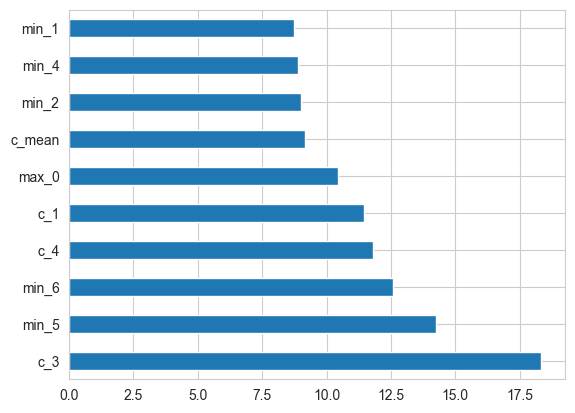

In [96]:
pd.Series(abs(svc_res[0].coef_[0]), index=feature_names).nlargest(10).plot(kind='barh');